In [20]:
from itertools import product
import pickle

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image, ImageOps

# Linear dimensionality reduction: Linear PCA
from sklearn.decomposition import PCA

# Non-linear dimensionality reduction: Kernel PCA
from sklearn.decomposition import KernelPCA

# DAISY feature extraction
from skimage.feature import daisy

matplotlib.rcParams.update({'figure.figsize': (15, 9)})
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'axes.labelsize': 20})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
matplotlib.rcParams.update({'font.family': 'Helvetica, Arial, sans-serif'})
%config InlineBackend.figure_format = 'retina'

sns.set_style("whitegrid")

# Machine Learning lab 3: exploring image data
## Jake Rowland and Paul Herz
2017-09-21

## 1. Introduction

In order to fulfill the requirements of this lab as well as future labs (presumably involving a prediction task), we sought a dataset with clear and unambiguous classes (pre-labelled). However, to avoid a classification task that was overly-ambitious, a small number of classes was ideal. We settled upon a labelled image dataset containing cats and dogs ([Kaggle](https://www.kaggle.com/c/dogs-vs-cats)).

### 1.1 Background

> Elson, Jeremy, John Douceur, Jon Howell, and Jared Saul. "Asirra." *Proceedings of the 14th ACM conference on Computer and communications security - CCS 07*, 2007. doi:10.1145/1315245.1315291 ([Libre PDF](https://www.microsoft.com/en-us/research/wp-content/uploads/2007/10/CCS2007.pdf)).

This dataset was furnished by Asirra (Animal Species Image Recognition for Restricting Access). Asirra is a CAPTCHA security challenge, i.e. a program designed to bar automated processes from accessing a system by forcing the user to prove their humanity. Asirra was an experiment in making a new and unique type of CAPTCHA, that would be trivial, less frustrating, and endearing to users.

Asirra pulls images of pets from Petfinder, an adoption service. These images are restricted to cats and dogs. Petfinder users have self-labeled these postings as cats or dogs during the upload process. Asirra challenges the user to identify a set of 12 images as either cats or dogs to proceed, and advertises an "Adopt me" button as a *quid pro quo* for using Petfinder's content. 

According to the abstract: 

>\[Asirra\] can be solved by humans 99.6% of the time in under 30 seconds, ... Barring a major advance in machine vision, we expect computers will have no better than a 1/54,000 chance of solving it.

Bear in mind that this was published in 2007. The one in 54,000 figure is an extremely pessimistic estimate, perhaps even a faulty one, as it is an ~8% piece of the probability of guessing randomly on a series of 12 binary choices ($0.5^{12}=1/4096$). So perhaps even for the time of its writing the figure is extreme, but even the figure for guessing randomly is poor (~0.02%).

There is little doubt that such a statement was interpreted as a challenge to the machine learning community, one that Kaggle worked with the Asirra (Microsoft Research) team to formalize in 2013. Asirra forwarded their dataset to Kaggle, and the "Dogs vs. Cats" challenge has been open ever since. According to Kaggle, classifying cats against dogs in this dataset is nontrivial due to the complexity and heterogeneity of the images:

> There is enormous diversity in the photo database (a wide variety of backgrounds, angles, poses, lighting, etc.), making accurate automatic classification difficult

In summary: whereas the original authors posited the success rate could not exceed 1:54000 with the contemporary state-of-the-art (SoA), the more realistic random choice success probability is 1:4096; an outdated poll states that the SoA per-image accuracy was 60% (1:459 success rate); the contemporary SoA for per-image accuracy is 80% (Golle, 2009), equating to a roughly 1:15 success rate (figures from Kaggle and Microsoft Research).

> Golle, P. (2009). Machine learning attacks against the Asirra CAPTCHA. *Proceedings of the 5th Symposium on Usable Privacy and Security - SOUPS 09*. doi:10.1145/1572532.1572585 ([Libre PDF](http://xenon.stanford.edu/~pgolle/papers/dogcat.pdf))

The purpose and worth of this dataset originated as a novel experiment in security controls and automation defeat mechanisms. However, it has become a relatively popular dataset, as well as a barometer of the SoA in image recognition and classification — it stands as a continual challenge to the ML community to further the SoA vis-à-vis this dataset's primary classification task.

### 1.2 Business Case

Classifying cats against dogs may not appear to have a business case *per se*. The academic endeavor that the dataset represents (*vide supra*, as a "barometer") is insufficient too as a viable case. To the original source of this data, Petfinder, there may be minor value to the service in this classification task. Petfinder's user-uploaded postings of adoptable animals are already hand-labeled during the upload process, but there may be a marketable, if not value-adding, "wow" factor to the service being able to automatically classify an animal based on the uploaded photo.

Another more slightly practical business case of this classification to Petfinder specifically would be the ability to integrate said capability into their moderation tools. This is a similar argument to the one we proposed for fraud and spam detection in Amazon comments in a prior assignment — finding discrepancies between the user-provided data and the classification tool as a piece in the pipeline of user content moderation. Any site on the order of size of Petfinder is sure to have staff and resources dedicated to moderation, and it would reduce expense (read "add value") to their moderation workflow if more probably mislabeled or misleading content was floated to the top of moderator's queues for review. The reduction of such incorrect content would "clean up" the site to an extent — user content is inherently chaotic but users want to see clean, well-formatted content. Chiefly, for an algorithm to be able to discern between cats, dogs, and potentially a third, null category, Petfinder could see postings where the user-labeled pet type did not match the photo, and perhaps more quickly regulate postings where there was no animal present in the photo.

We see this second case as being a more viable integration into the business of Petfinder specifically, or animal adoption/listing sites more generally. Provided that the dataset is *from* Petfinder, and therefore best represents the content *of* Petfinder, we chose to mention the case specifically relative to them. The second business case truly adds value and efficiency to Petfinder's content management, which directly affects the perceived quality of the site.

### 1.3 Serviceability

The introduction to the dataset on Kaggle, as well as research into adversaries to Asirra (i.e. predictors on this dataset), have chosen to quantify potential classification algorithms which operate on this dataset in terms of **accuracy**. Percentage figures above, under *Background*, have replicated the language of these texts, referring to **accuracy**. Here, the term refers specifically to the percent of *individual images* that a given algorithm can properly classify as either cat or dog. *Separately,* and not to be confused with the usage of "accuracy," is the term **success rate**. The figures above have displayed success rate in terms of a ratio $1:x$, that is, the "one-in-x odds" of successfully identifying not a single photo, but the full panel of twelve photos. Accuracy here is an observed value, but success rate is computed in terms of accuracy through the multiplicative rule of independent probabilities as $S=a^{12}$.

It is easier to speak in terms of the performance of the algorithm in terms of success on a single image, that is, once again, **accuracy**. As stated, the state-of-the-art for accuracy across this dataset is 80% (Golle, 2009). In order for our implementation to be serviceable, i.e. how well it would need to perform to be of use, we would have to beat out the state-of-the-art: even though theoretically, to fulfill our business case we do not need to beat out all of academia, it would neither be a meaningful contribution to the academic community nor to a client (e.g. Petfinder) if there was already an existing algorithm of higher caliber.

As such, we believe that for our algorithm to be useful, we would need our algorithm to perform at 81% accuracy on a per-image basis across the dataset. We believe that one percentage point is a significant enough separator between our hypothetical algorithm and the state-of-the-art to represent a sufficiently meaningful contribution to academia and clients under our business case.

## 2. The dataset: preprocessing and review

### 2.1 Dataset preparation

We will load the dataset and modify it outright for the sake of computational efficiency. This forgoes the usual preliminary superficial analysis, which will follow after this step. The original dataset is large (25,000 images, 572MB) when compared to the minimal requirements of this assignment (≥1000 images), and can be downscaled (≥20px squared), as well as stripped of color.

First, we establish a standard size to which all images will be resized. This is a prerequisite for making the results of later operations (dimensionality reduction, feature extraction) meaningful, that is, comparing apples to apples.

In [2]:
image_size = (64, 64)

Now, loading a subset of images (500 dog images, and 500 cat images):

In [3]:
%%time

# the directory immediately under which all the images
# reside.
file_prefix = 'data/'

# The PIL flag for grayscale.
GRAYSCALE_MODE = 'L'

# Will store tuples (id,image_data,is_dog) and then
# will be converted into the DataFrame `images`.
images_list = []

# load data/cat.0.jpg to data/cat.499.jpg, 
# then data/dog.0.jpg to data/dog.499.jpg.
for pet_type, index in product(['cat', 'dog'], range(500)):
    file_name = f'{pet_type}.{index}'
    
    # Load and convert to grayscale
    image = Image.open(f'{file_prefix}{file_name}.jpg').convert(mode=GRAYSCALE_MODE)
    
    # Aspect fit the image (shrink the image while maintaining
    # the aspect ratio such that the shorter dimension matches its target value
    # in image_size above. Then center it and crop off the excess to fit in
    # the dimensions of image_size).
    image = ImageOps.fit(image, image_size, method=Image.ANTIALIAS)
    
    # The PIL.ImageData object is essentially a matrix. Linearize it as a numpy array.
    data = np.asarray(image.getdata())
    
    # Add the boolean field `is_dog` as a simple representation of our cat/dog dichotomy.
    is_dog = (pet_type == 'dog')
    images_list.append((file_name,data,is_dog))

images = pd.DataFrame(data=images_list,columns=['id','image_data','is_dog'])

CPU times: user 6.21 s, sys: 59.3 ms, total: 6.27 s
Wall time: 6.28 s


In [4]:
images.head()

,id,image_data,is_dog
0,cat.0,"[204, 206, 207, 210, 213, 214, 218, 208, 184, ...",False
1,cat.1,"[43, 40, 42, 41, 56, 39, 40, 40, 43, 38, 38, 5...",False
2,cat.2,"[134, 218, 218, 209, 208, 196, 104, 132, 115, ...",False
3,cat.3,"[137, 114, 118, 150, 194, 212, 206, 204, 204, ...",False
4,cat.4,"[182, 182, 185, 186, 186, 185, 188, 190, 190, ...",False


Now we have 1000 images: 500 cats, 500 dogs, in grayscale, resized down to 64x64 while maintaining aspect ratio (fit-cropping). However there is one optimization to be made: When provided the image data objects, effectively wrapped arrays of integer values 0-255 (8 bit), Numpy stored them as Numpy Arrays of Integers. The default Numpy integral type is `int64`, eight times what is necessary to store these 8-bit grayscale values. We recast each image data array to `uint8` for savings.

In [5]:
old_memory_usage = images.memory_usage(deep=True).sum()
images.image_data = images.image_data.apply(lambda data: data.astype('uint8'))
new_memory_usage = images.memory_usage(deep=True).sum()
print('Old size:',old_memory_usage/1000000.,'MB')
print('New size:',new_memory_usage/1000000.,'MB')
print('Savings of', 100.0*(old_memory_usage-new_memory_usage)/old_memory_usage, 'percent!')

Old size: 32.93686 MB
New size: 4.26486 MB
Savings of 87.0514068433 percent!


###### 2.2 Data quality
This section would typically be "Data quality and modification," but due to the nature of this data, we sought to modify it in a streaming fashion as it was loaded. Instead, we will directly review data quality, and may analyze the nature of the modified image data (64x64 aspect filled, grayscale). First, recall the structure of the dataset.

In [6]:
images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
id            1000 non-null object
image_data    1000 non-null object
is_dog        1000 non-null bool
dtypes: bool(1), object(2)
memory usage: 16.7+ KB


The `id` field merely references the source filename, as the dataset resides in the filesystem. By the nature of how the dataset was loaded (from file), it is not possible for one to be missing. The `image_data` field is the same (superficially complete), but we must assume the images are well-formed, not corrupted, etc. until we inspect them visually. `is_dog` is a field, much like `id`, that we've added based on the filenames, since they are pre-labeled `cat` or `dog`. Assigning this field as a boolean seemed appropriate as the classes are binary. It too is complete in the superficial sense, and we must assume the labels are correct unless we analyze all 1000 images manually.

In [7]:
# [CITE] "04. Dimension Reduction and Images Notebook" by Eric Larson

def plot_gallery(imgs, titles, size, rows=3, cols=6):
    plt.figure(figsize = (1.7 * cols, 2.3 * rows))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    
    for i in range(rows * cols):
        plt.subplot(rows, cols, i+1)
        ax = plt.gca()
        [spine.set_color('black') for _,spine in ax.spines.items()]
        plt.imshow(imgs[i].reshape(size), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks([]); plt.yticks([])
    plt.show()

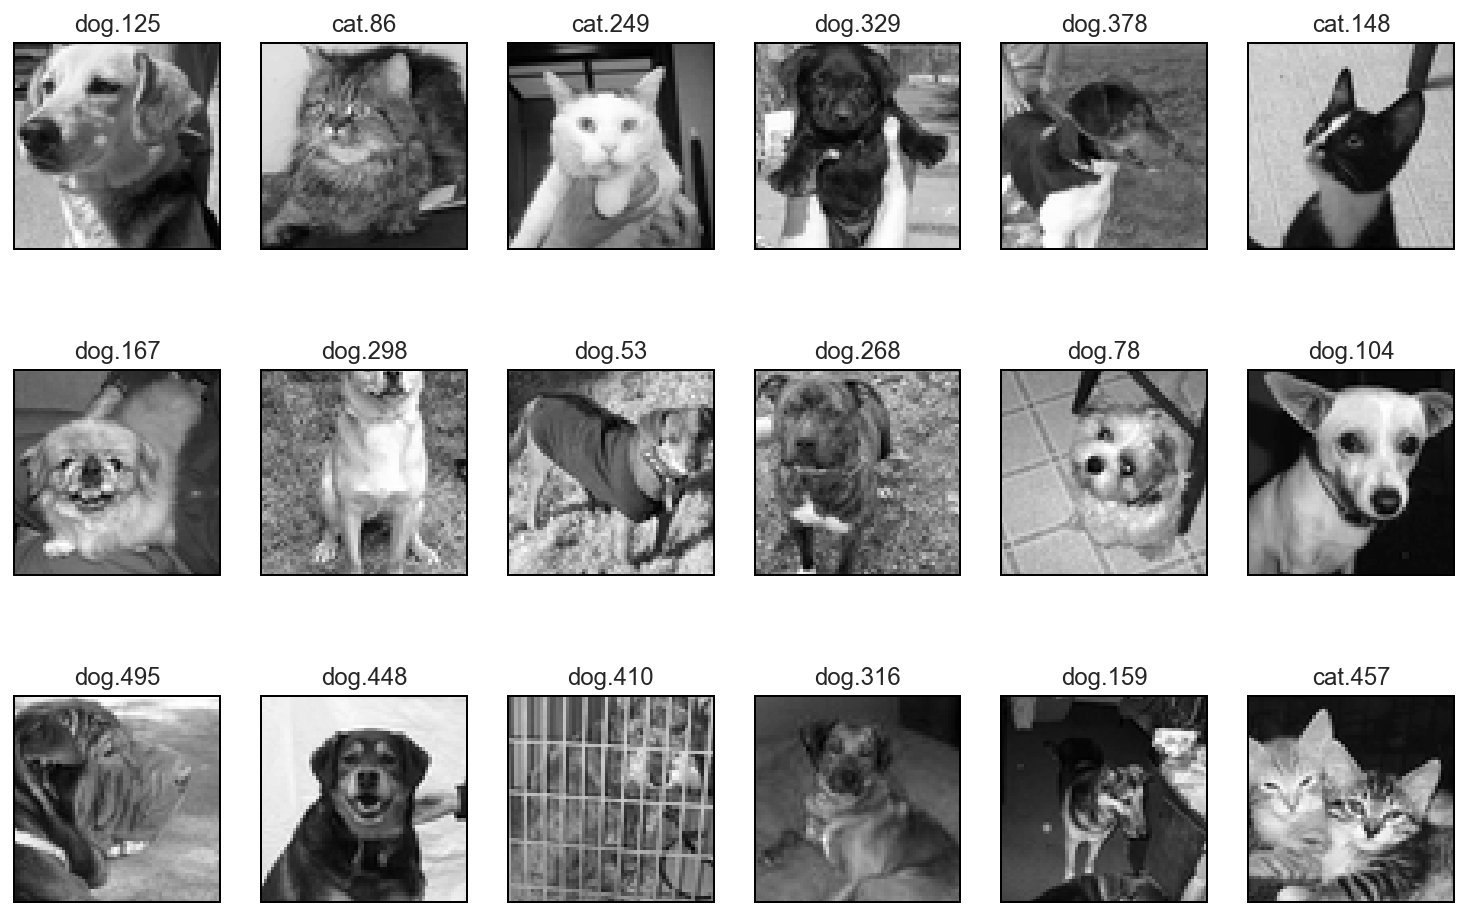

In [8]:
some_images = images.sample(n=18)
plot_gallery(some_images.image_data.iloc, some_images.id.iloc, image_size)

As mentioned earlier, data quality can be determined either in superficial terms or more deep-diving terms. Upon looking at this random selection of images, the challenge of this dataset becomes clear. Although it is "complete" and "well-formed" in the sense that all images have loaded and are not garbled or noisy, these animals are depicted in an extremely wide variety of:

1. Postures
2. Angles (heads looking sideways or away)
3. Lighting situations
4. Areas of the image (full, corner, etc.)
5. Settings (humans, backgrounds, cages)

Unlike the example dataset presented in the lecture, of cropped, well-lighted faces of a small set of well-known people, this dataset provides no consistency across the spacial or luma domains. The most difficult part of this dataset is images where animals are obstructed by cages, pictured with humans, or worse yet, with other animals. In the following sections, we will attempt dimensionality reduction and feature extraction techniques and determine how successful they are in classifying this difficult dataset.

## 3. Dimensionality reduction techniques

### 3.1 Linear dimensionality reduction: linear principal component analysis (Linear PCA)

We will perform PCA on all of the images on `test_components_count` number of components, as defined below. We display the "eigenpets" (principal components) and explained variance. The number of components is arbitrarily larger than the ideal number, that minimizes computation while still acheiving 90% accuracy. We will use the results of this first PCA round to find the ideal number of components.

In [9]:
# The column `image_data` in the `images` DataFrame
# is a pandas Series. Convert it to a (1000,64^2) matrix,
# where 1000 is the number of images and 64^2 is the linear
# size of a single image.
image_matrix = np.asarray(images.image_data.tolist())

In [10]:
# [CITE] "04. Dimension Reduction and Images Notebook" by Eric Larson
# i.e. the number of dimensions
test_components_count = 300

def linear_pca(n_components, matrix):
    pca = PCA(n_components=n_components)
    %time pca.fit(matrix)
    return pca

def get_eigenpets(pca):
    # eigenpets will be the principal components, reshaped as a 3D matrix:
    # [component_number][x][y], i.e. an array of 2D images.
    return pca.components_.reshape((pca.n_components, *image_size))

def plot_eigenpets(eigenpets):
    eigenpets_titles = [f'eigenpet {i}' for i in range(eigenpets.shape[0])]
    plot_gallery(eigenpets, eigenpets_titles, image_size)

In [11]:
test_pca = linear_pca(test_components_count, image_matrix)

CPU times: user 1.82 s, sys: 148 ms, total: 1.97 s
Wall time: 873 ms


#### Visualizing eigenpets (principal components)

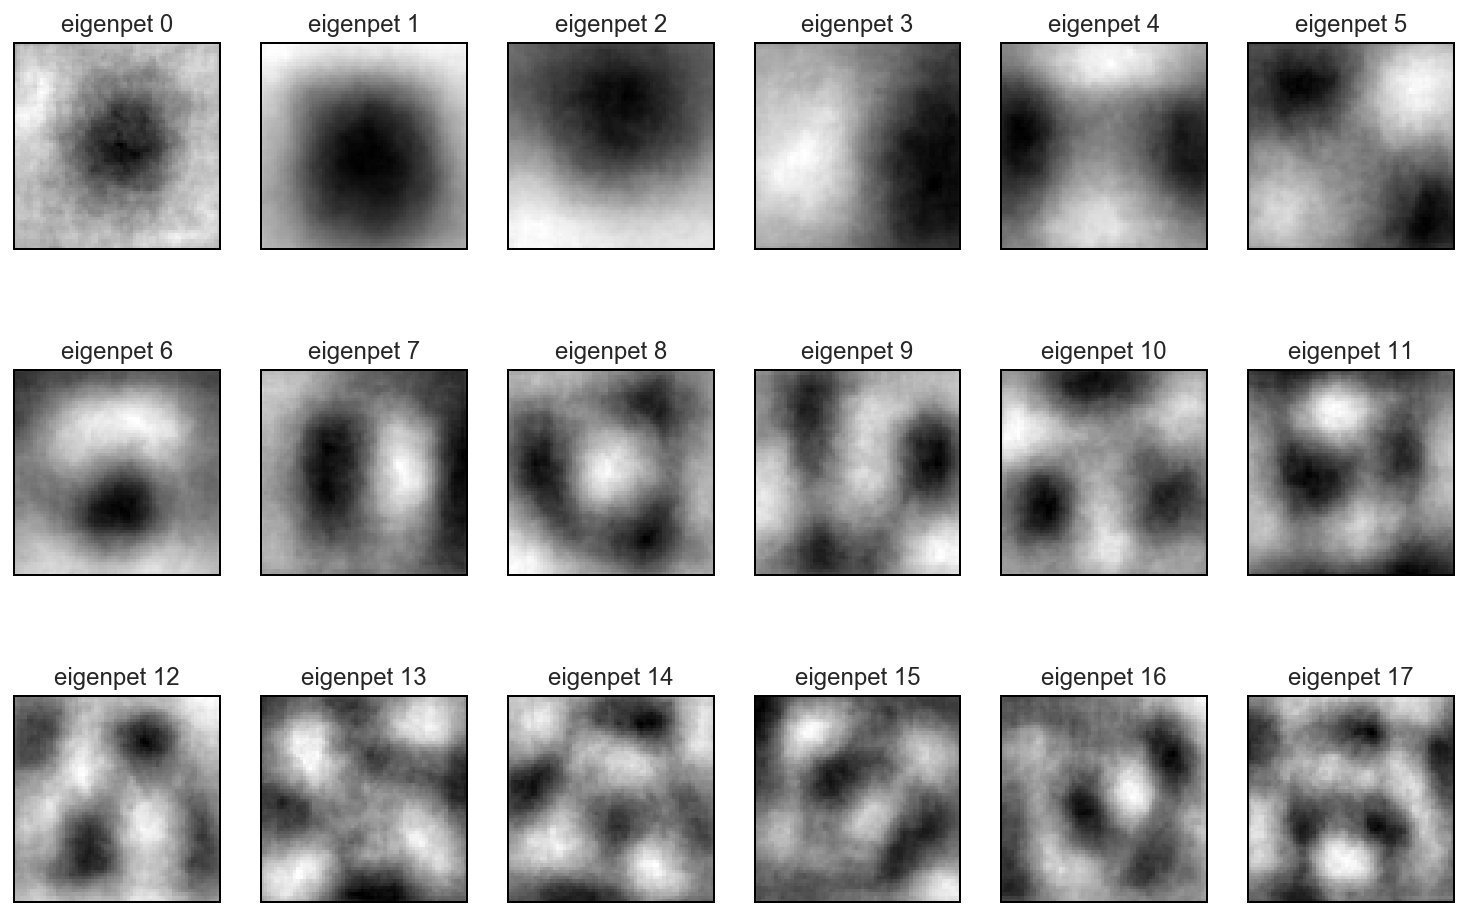

In [12]:
eigenpets = get_eigenpets(test_pca)
plot_eigenpets(eigenpets)

#### Visualizing explained variance

In [13]:
# [CITE] "04. Dimension Reduction and Images Notebook" by Eric Larson

def pca_comp_range(p):
    return np.arange(0,p.n_components)

def explained_var(p):
    return p.explained_variance_ratio_

def cumulative_explained_var(p):
    return np.cumsum(explained_var(p))

def find_nearest_x_for_y(x,y,value):
    index = np.abs(y-value).argmin()
    return x[index]

def find_90_percent_dimension_count(p):
    return find_nearest_x_for_y(pca_comp_range(p), cumulative_explained_var(p),0.9)

def plot_explained_variance(pca):    
    fig, g = plt.subplots()
    cr = pca_comp_range(pca)
    expvar = explained_var(pca)
    cumexpvar = cumulative_explained_var(pca)
    
    g.fill_between(cr, 0, expvar, color='blue', 
        label='individual explained variance')
    g.plot(cr, cumexpvar, color='orange', linestyle='-', marker='', 
        label='cumulative explained variance')
    g.axhline(y=0.9,color='gray',linestyle='--', 
        label='90% accuracy target')
    
    g.set(xlabel='Principal components',ylabel='Explained variance ratio',
        xlim=(0,pca.n_components),ylim=(0,1),
        title='Explained variance of components')
    g.legend(loc='lower right')
    plt.show()

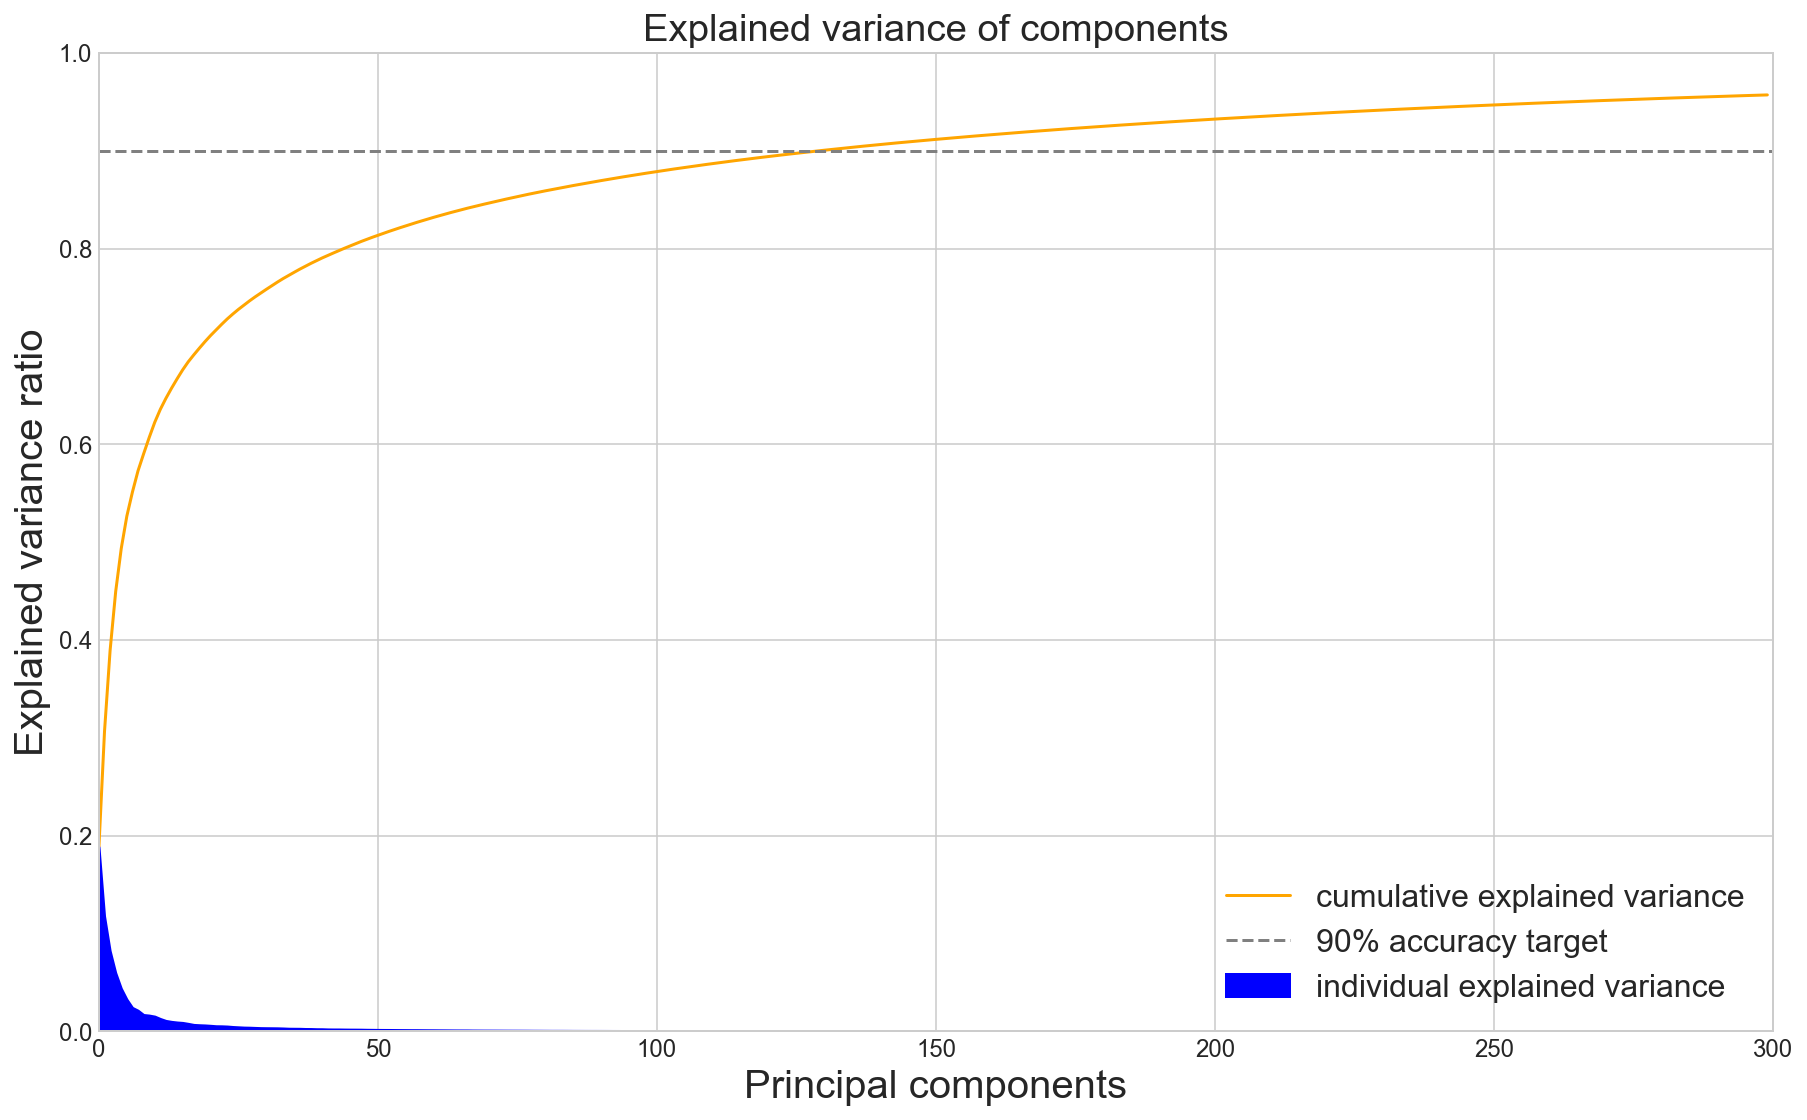

In [14]:
plot_explained_variance(test_pca)

#### Finding the appropriate number of dimensions for linear PCA
In class, it was stated that 90% was an acceptable target for the explained variance ratio. In the above chart, we see the individual explained variance of principal components charted out from 0...500, and an orange line describing the cumulative explained variance. We have drawn a horizontal line depicting the target cumulative explained variance, 90%.

The following function will find the approximate x location of the intersection, i.e. the number of dimensions we will need to have 90% cumulative explained variance.

In [15]:
ideal_components_count = find_90_percent_dimension_count(test_pca)
print(f'The number of dimensions needed to achieve 90% accuracy in linear PCA is {ideal_components_count}')

The number of dimensions needed to achieve 90% accuracy in linear PCA is 129


We could truncate the principal components, but that would render the statistics stored in the PCA object inaccurate. We will perform linear PCA again with the newly recommended number of dimensions.

In [16]:
pca = linear_pca(ideal_components_count, image_matrix)

CPU times: user 911 ms, sys: 87.4 ms, total: 998 ms
Wall time: 424 ms


If the first several eigenpets were to be plotted again, they would be the same — reducing the number of components does not change the values of any components still included therein.

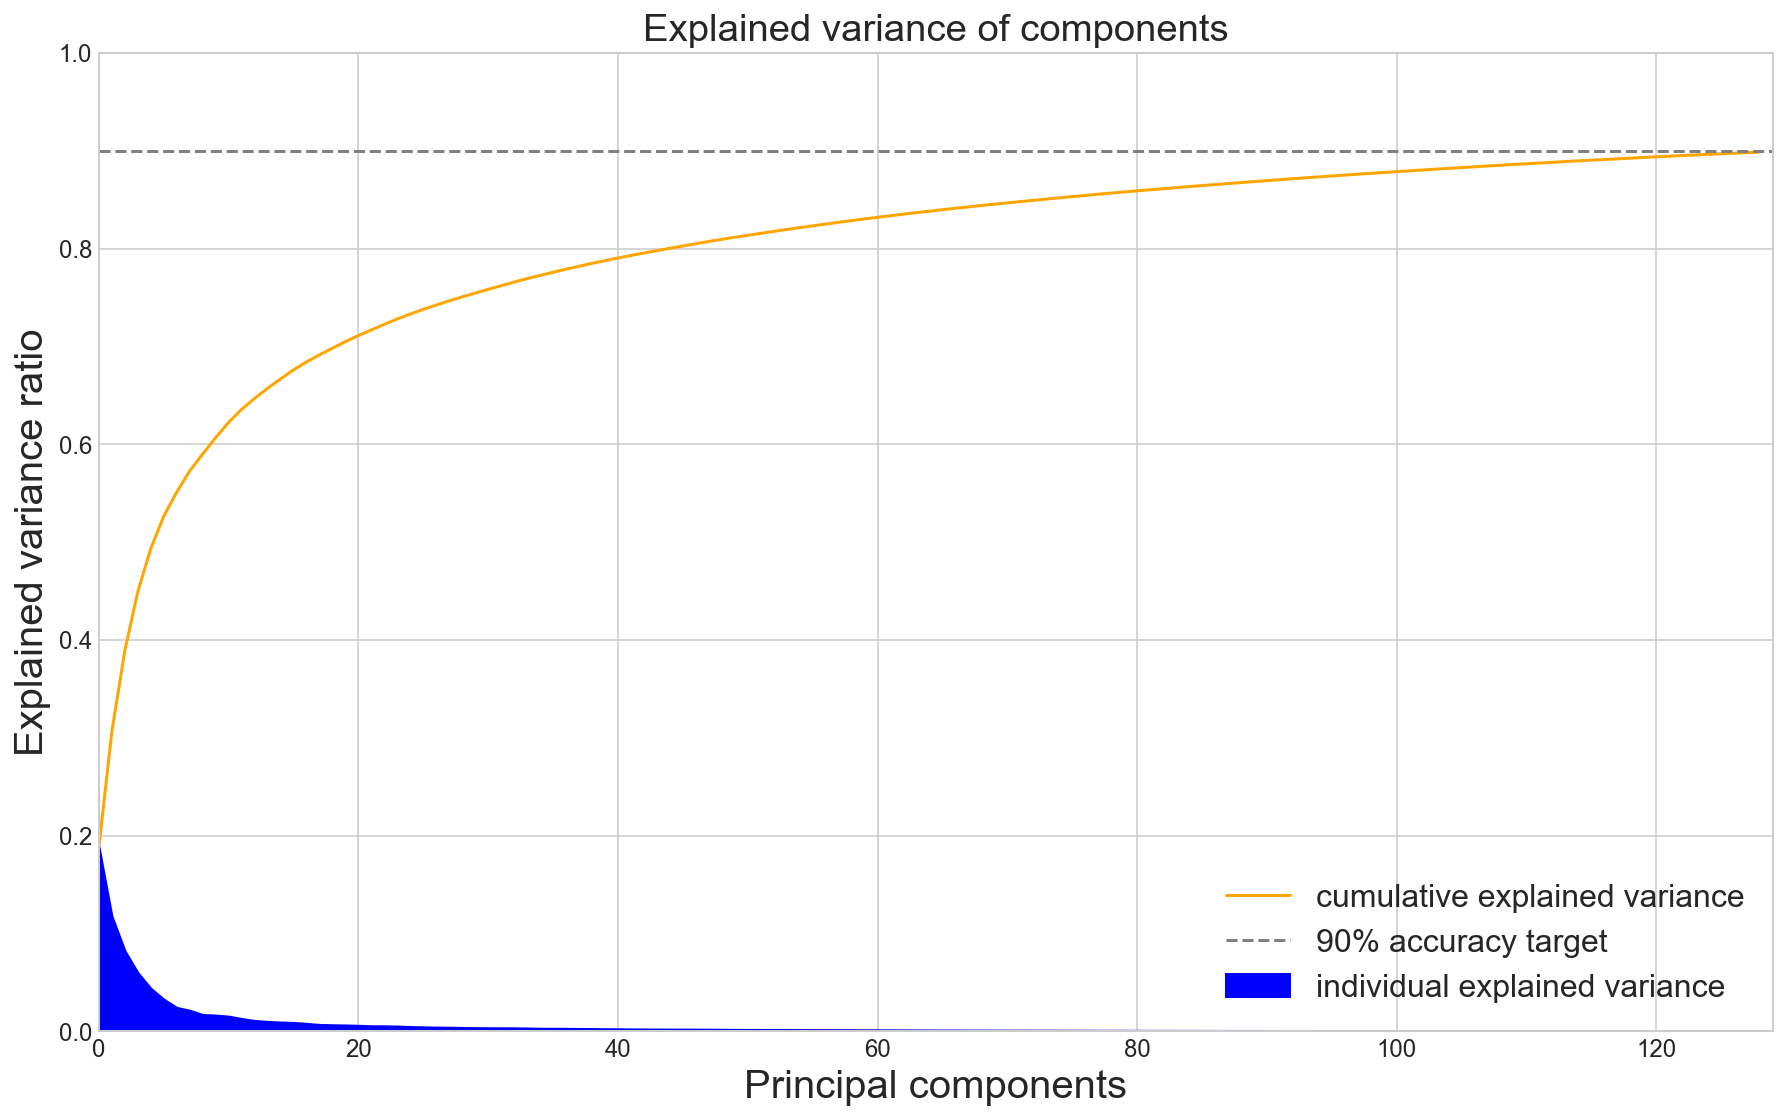

In [17]:
plot_explained_variance(pca)

Affirming our assumptions, the new PCA with a smaller number of components amounts to a truncation of the original array of principal components. And it reaches 90% almost exactly.

**Rationale:** we did not rely on guess-and-check or other methodologies for determining the ideal number of dimensions for the linear PCA. We used a procedural methodology to find a component count that fulfilled a simple requirement: 0.9 cumulative explained variance. We believe this methodology is objective enough to be a trustworthy approach.

### 3.2 Non-linear dimensionality reduction: kernel principal component analysis (Kernel PCA)

Now we will repeat the above process with a non-linear dimensionality reduction technique: that of kernel principal component analysis (kernel PCA). Since the kernel PCA does not have the same "components" (according to `scikit`), we cannot produce the same eigenpet diagrams.

We will, however, compare the kernel PCA with the linear PCA, and in the interest of fairness, we will match the component count used in the Linear PCA: `ideal_components_count`.

In [18]:
def kernel_pca(n_components, matrix):
    kpca = KernelPCA(
        n_components=n_components, 
        kernel='rbf', 
        fit_inverse_transform=True, 
        gamma=15, 
        remove_zero_eig=True
    )
    %time kpca.fit(matrix)
    return kpca

Calculating the kernel PCA takes a very long time. The following code will first attempt to load a serialized copy of the PCA from the `data/` folder, and otherwise will recalculate it and save it.

In [19]:
kpca = False
kpca_file_name = f'{file_prefix}kernel_pca.p'
try:
    kernel_file = open(kpca_file_name,'rb')
    kpca = pickle.load(kernel_file)
    print('Reloaded the kernel PCA from file.')
except OSError:
    print('No kernel PCA file found. Regenerating kernel PCA... (go grab a coffee!)')
    kpca = kernel_pca(ideal_components_count, image_matrix)
    pickle.dump(kpca, open(kpca_file_name,'wb'))

No kernel PCA file found. Regenerating kernel PCA... (go grab a coffee!)
CPU times: user 33.9 s, sys: 485 ms, total: 34.3 s
Wall time: 31.6 s


### 3.3 Comparing the linear PCA and the kernel PCA
In order to compare the the performance and serviceability of the linear PCA versus the kernel PCA, we will employ a common and intuitive visualization: reconstruction of source images through an inverse transformation.

In [70]:
# [CITE] "04. Dimension Reduction and Images Notebook" by Eric Larson
def reconstruct_image(transformer,features):
    low_dimensional_representation = transformer.transform(features)
    reconstruction = transformer.inverse_transform(low_dimensional_representation)
    # return low_rep, rec_image
    return reconstruction

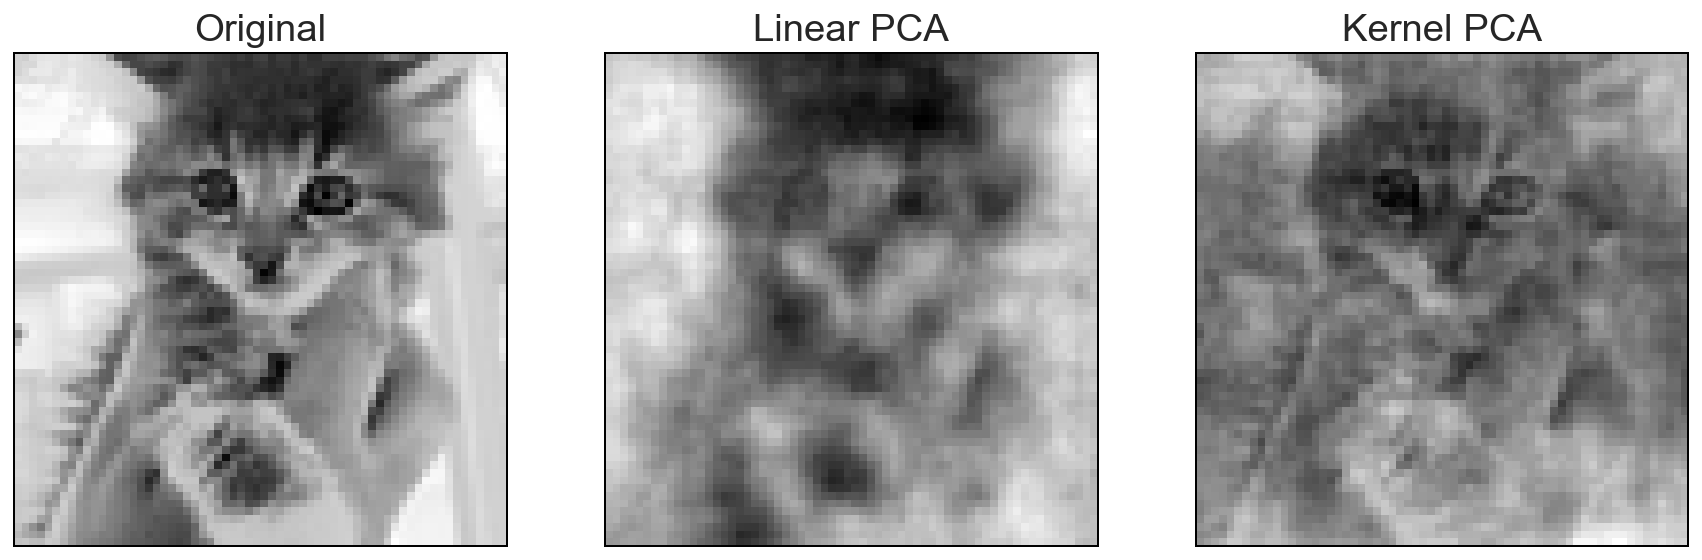

In [75]:
index_to_reconstruct = 100
features_to_reconstruct = images.iloc[index_to_reconstruct].image_data.reshape(1,-1)

original_image = features_to_reconstruct.reshape(image_size)
linear_pca_reconstruction = reconstruct_image(pca,features_to_reconstruct).reshape(image_size)
kernel_pca_reconstruction = reconstruct_image(kpca,features_to_reconstruct).reshape(image_size)

diff = np.subtract(original_image,kernel_pca_reconstruction)
gallery = {
    'Original': original_image,
    'Linear PCA': linear_pca_reconstruction,
    'Kernel PCA': kernel_pca_reconstruction
}
for i, (title, image) in enumerate(gallery.items()):
    ax = plt.subplot(1,len(gallery),i+1)
    plt.imshow(image, cmap=plt.cm.gray)
    plt.title(title)
    plt.grid(False)
    [spine.set_color('black') for _,spine in ax.spines.items()]
    plt.xticks([]); plt.yticks([])
plt.show()

The results of this are extremely interesting. We had to cherry pick for a while to find an image that best presented a challenge of accuracy to both dimensionality reduction methods, but in different ways. On the first testing image, kernel PCA was so indistinguishable from perfect that we were (and continue to be) suspicious that there may have been a programming error. What is more likely, however, is the following: the images have been reduced down to little more than 4 MB, and the serialized Kernel PCA state is 38.9 MB on disk. It is possible that the Kernel PCA is able to reconstruct the image so sharply because it contains a superset of the dataset in its state. We would need to look into how Kernel PCAs work further to understand this.

Unlike prior images wherein the Kernel PCA reconstruction was indistinguishable from the original, this image shows both PCAs performing passably (enough to be recongizable) on an image whose composition is sufficiently different from the rest so as to be difficult to reconstruct. Whereas the Linear PCA did a better job of preserving the overall exposure of the image, i.e. global luma accuracy, the kernel PCA sharply renders the cat in the image, but appears to be overlaid with noise from other images. The above hypothesis regarding Kernel PCAs, albeit uninformed, could explain the high level of detail.

We prefer the Kernel PCA due to its performance on average (as opposed to in this pathological example). Data is still discernable through images even when they do not render particularly well. The only drawbacks or matters of concern are that the Kernel PCA appears to outsize the dataset on which it is based, and that it takes an incredibly long time to calculate up front relative to the Linear PCA.

## 4. Feature extraction